# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 5
### Jonas Lundgren

### GloVe embeddings

Code provided in lab instructions.

In [1]:
%matplotlib inline

from PIL import Image
import glob
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB

In [2]:
# ---------------------------------------------------------------- #
# This code is mainly from the EDAN95 fall term lab session No 6,
# provided by Volker Krueger
# ---------------------------------------------------------------- #

class MNISTData :

    def __init__(self, dir):

        filelist = sorted(glob.glob(dir))
        self.x = np.array([np.array(Image.open(fname)) for fname in filelist])

        self.samples_per_class = 500
        self.number_of_classes = 10

        self.y = np.zeros(self.number_of_classes * self.samples_per_class,dtype=int)
        for cls in range(1,self.number_of_classes):
            self.y[(cls*500):(cls+1)*500] = cls


    def get_data(self):

        self.train_features, self.test_features, self.train_labels, self.test_labels = train_test_split(self.x, self.y, test_size=0.3,
                                                                                    random_state=42)
        self.train_normalised = self.train_features.reshape(3500, 400) / 255.0
        self.test_normalised = self.test_features.reshape(1500, 400) / 255.0

        return self.train_normalised, self.test_normalised, self.train_labels, self.test_labels


    def visualize_random(self):

        examples_per_class = 8
        for cls in range(self.number_of_classes):
            idxs = np.where(self.train_labels == cls)[0]
            idxs = np.random.choice(idxs, examples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt.subplot(examples_per_class, self.number_of_classes, i * self.number_of_classes + cls + 1)
                plt.imshow(self.train_features[idx].astype('uint8'), cmap='gray')
                plt.axis('off')
                if i == 0:
                    plt.title(str(cls))
        plt.show()

    def visualize_wrong_class(self, pred, examples_per_class):
        for cls in range(self.number_of_classes):
            idxs = [idx for idx, value in enumerate(self.test_labels) if((value != cls) and (pred[idx] == cls))]
            if(len(idxs) > examples_per_class):
                idxs = np.random.choice(idxs, examples_per_class, replace=False)

            for i, idx in enumerate(idxs):
                plt.subplot(examples_per_class, self.number_of_classes, i * self.number_of_classes + cls + 1)
                plt.imshow(self.test_features[idx].astype('uint8'), cmap='gray')
                plt.axis('off')
                if i == 0:
                    plt.title(str(cls))
        plt.show()

## 1. Classifiers you should implement

### Provided Gaussian NB Classifier

Code provided from lab instructions changed to be able to take the different data sets specifyed by the `data` parameter in the model which can be set to the 3 data sets: `mnist`, `digits` or `sigits_summarised`.

In [3]:
def scikit_GaussianNB(data = "mnist"):
    
    if data == "mnist":
        mnist = MNISTData('Handout_NaiveBayes/MNIST_Light/*/*.png')
        train_features, test_features, train_labels, test_labels = mnist.get_data()
        mnist.visualize_random()
    elif data == "digits":
        digits = load_digits()
        train_features, test_features, train_labels, test_labels = train_test_split(digits.images, digits.target,
                                                                            test_size=0.3, random_state=42)
        train_features = train_features.reshape([len(train_features), -1])
        test_features = test_features.reshape([len(test_features), -1])
        
    elif data == "digits_summarised":
        digits = load_digits()
        train_features, test_features, train_labels, test_labels = train_test_split(digits.images, digits.target,
                                                                            test_size=0.3, random_state=42)
        train_features[train_features < 5] = 0.
        train_features[(train_features >= 5) & (train_features < 11)] = 1.
        train_features[train_features >= 11] = 2.
        
        test_features[test_features < 5] = 0.
        test_features[(test_features >= 5) & (test_features < 11)] = 1.
        test_features[test_features >= 11] = 2.
        
        train_features = train_features.reshape([len(train_features), -1])
        test_features = test_features.reshape([len(test_features), -1])

    gnb = GaussianNB()
    gnb.fit(train_features, train_labels)
    y_pred = gnb.predict(test_features)

    print("Classification report SKLearn GNB:\n%s\n"
      % (metrics.classification_report(test_labels, y_pred)))
    print("Confusion matrix SKLearn GNB:\n%s" % metrics.confusion_matrix(test_labels, y_pred))
    
    if data == "mnist":
        mnist.visualize_wrong_class(y_pred, 8)

### Nearest Centroid Classifier (NCC)

My implementation of the Nearest Centroid Classifier. Same result as `sklearn.neighbors.NearestCentroid`.

In [4]:
class NearestCentroidClassify():
    """
    Implementation of Nearest Centroid Classifyer
    """        
    def fit(self, X, y):
        
        (n_observations, n_features) = np.shape(X)
        classes = np.unique(y)
        n_classes = len(classes)
        
        self.centroids = np.empty((n_classes, n_features), dtype=np.float64)
        
        for current_class in classes:
            
            self.centroids[current_class] = X[y == current_class].mean(axis=0)
        return self
    
    def predict(self, X):
        
        preds = np.empty(len(X), dtype = np.int32)
        
        for i, x in enumerate(X):
            #predicts the class for which the euclidean distance (l2 norm) is lowest among the centroids
            preds[i] = np.argmin([np.linalg.norm(x - centroid, 2) for centroid in self.centroids])
        
        self.preds = preds
        return self.preds

In [5]:
def my_NCC(data = "mnist"):
    if data == "mnist":
        mnist = MNISTData('Handout_NaiveBayes/MNIST_Light/*/*.png')
        train_features, test_features, train_labels, test_labels = mnist.get_data()
        mnist.visualize_random()
    elif data == "digits":
        digits = load_digits()
        train_features, test_features, train_labels, test_labels = train_test_split(digits.images, digits.target,
                                                                            test_size=0.3, random_state=42)
        train_features = train_features.reshape([len(train_features), -1])
        test_features = test_features.reshape([len(test_features), -1])
        
    elif data == "digits_summarised":
        digits = load_digits()
        train_features, test_features, train_labels, test_labels = train_test_split(digits.images, digits.target,
                                                                            test_size=0.3, random_state=42)
        
        train_features[train_features < 5] = 0.
        train_features[(train_features >= 5) & (train_features < 11)] = 1.
        train_features[train_features >= 11] = 2.
        
        test_features[test_features < 5] = 0.
        test_features[(test_features >= 5) & (test_features < 11)] = 1.
        test_features[test_features >= 11] = 2.
        
        train_features = train_features.reshape([len(train_features), -1])
        test_features = test_features.reshape([len(test_features), -1])
    
    ncc = NearestCentroidClassify()
    ncc.fit(train_features, train_labels)
    y_pred = ncc.predict(test_features)

    print("Classification report NearestCentroidClassify:\n%s\n"
      % (metrics.classification_report(test_labels, y_pred)))
    print("Confusion matrix NearestCentroidClassify:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

    if data == "mnist":
        mnist.visualize_wrong_class(y_pred, 8)

### Naive Bayesian Classifier (NBC)

Implementation of `NaiveBayesianClassifier` https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html.

In [6]:
class NaiveBayesianClassifier():
        
    
    def fit(self, X, y, data = "mnist"):
        
        self.classes, counts = np.unique(y, return_counts=True)
        n_obs, n_rows, n_cols = np.shape(X)
        pixel_values = np.unique(X.flatten())
        cond_prob = {}

        for current_class in self.classes:
            class_pixel = {}
            X_current_class = X[y == current_class]
            
            for k, (i,j) in enumerate(product(range(n_rows), range(n_cols))):
                
                pixel_val_counts = np.zeros(len(pixel_values))
                #Get unique the number of unique values and their position
                pos, n_uniques = np.unique(X[y == current_class][:,i,j], return_counts=True)
                #Set the number number of unique values at corresponding position
                pixel_val_counts[pos.astype(np.int8)] = n_uniques
                #Normalize to be probabilities using add-one or Laplace smoothing
                if data == "mnist":
                    class_pixel[k] = (pixel_val_counts) / np.sum(pixel_val_counts)
                else:
                    class_pixel[k] = (pixel_val_counts + 1) / np.sum(pixel_val_counts + 1)
                
            cond_prob[current_class] = class_pixel
            
        self.cond_prob = cond_prob
        self.priors = counts / np.sum(counts)
    
    def predict(self, X):
        
        preds = np.zeros(len(X), dtype = np.int32)
        n_obs, n_rows, n_cols = np.shape(X)
        
        for n, x in enumerate(X):
            probs = np.zeros(len(self.classes))
            for current_class in self.classes:
                prob = self.priors[current_class]
                for k, (i,j) in enumerate(product(range(n_rows), range(n_cols))):
                    #Take the conditional probability at of having pixelvalue x[i,j] 
                    #at the (i,j):th = n:th pixel for current class
                    #prob += np.log(self.cond_prob[current_class][k][int(x[i,j])])
                    prob *= self.cond_prob[current_class][k][int(x[i,j])]
                
                probs[current_class] = self.priors[current_class] * prob

            preds[n] = np.argmax(probs)
    
        self.preds = preds
        return self.preds

In [7]:
def my_NBC(data = "mnist"):   
    
    if data == "mnist":
        mnist = MNISTData('Handout_NaiveBayes/MNIST_Light/*/*.png')
        train_features, test_features, train_labels, test_labels = mnist.get_data()
        mnist.visualize_random()
        
        n_train, pixels = np.shape(train_features)
        dim = int(np.sqrt(pixels))
        
        train_features = train_features.reshape([len(train_features), dim, dim])
        test_features = test_features.reshape([len(test_features), dim, dim])
        
    elif data == "digits":
        digits = load_digits()
        train_features, test_features, train_labels, test_labels = train_test_split(digits.images, digits.target,
                                                                            test_size=0.3, random_state=42)
        
    elif data == "digits_summarised":
        digits = load_digits()
        train_features, test_features, train_labels, test_labels = train_test_split(digits.images, digits.target,
                                                                            test_size=0.3, random_state=42)
        
        train_features[train_features < 5] = 0.
        train_features[(train_features >= 5) & (train_features < 11)] = 1.
        train_features[train_features >= 11] = 2.
        
        test_features[test_features < 5] = 0.
        test_features[(test_features >= 5) & (test_features < 11)] = 1.
        test_features[test_features >= 11] = 2.
        
        
    nbc = NaiveBayesianClassifier()
    if data == "mnist":
        nbc.fit(train_features, train_labels)
    else: 
        nbc.fit(train_features, train_labels, "digits")
    y_pred = nbc.predict(test_features)

    print("Classification report NaiveBayesianClassifier:\n%s\n"
      % (metrics.classification_report(test_labels, y_pred)))
    print("Confusion matrix NaiveBayesianClassifier:\n%s" % metrics.confusion_matrix(test_labels, y_pred))
    
    if data == "mnist":
        mnist.visualize_wrong_class(y_pred, 8)

### Gaussian Naive Bayesian Classifier (GNB) 

In [8]:
class GaussianNaiveBayesianClassifier():
    
    
    def log_gaussian(self, x, mu, sigma):
        """
        Returns Gaussian and 0 if mu or sigma is 0 
        """
        if any(np.isclose([sigma, mu], 0)):
            return np.zeros(1)
        else:
            #return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x - mu)**2 / (2 * sigma**2))
            return (-(x - mu)**2 / (2 * sigma**2))
        
    
    def fit(self, X, y):
        
        self.classes = np.unique(y)
        
        means = {}
        stds = {}

        for current_class in self.classes:
            means[current_class] = np.mean(X[y == current_class], axis=0)
            stds[current_class]  = np.std(X[y == current_class], axis=0)
            
        self.means = means
        self.stds = stds
    
    def predict(self, X):
        
        preds = np.empty(len(X), dtype = np.int32)
        log_gaussian = np.vectorize(self.log_gaussian)
        
        for i, x in enumerate(X):
            probs = np.zeros(len(self.classes))
            for current_class in self.classes:
                prob = log_gaussian(x, self.means[current_class], self.stds[current_class])
                probs[current_class] = np.sum(prob)
                
            preds[i] = np.argmax(probs)
            
        self.preds = preds
        return self.preds

In [9]:
def my_GNBC(data = "mnist"):    
    if data == "mnist":
        mnist = MNISTData('Handout_NaiveBayes/MNIST_Light/*/*.png')
        train_features, test_features, train_labels, test_labels = mnist.get_data()
        mnist.visualize_random()
        
        n_train, pixels = np.shape(train_features)
        dim = int(np.sqrt(pixels))
        
        train_features = train_features.reshape([len(train_features), dim, dim])
        test_features = test_features.reshape([len(test_features), dim, dim])
        
    elif data == "digits":
        digits = load_digits()
        train_features, test_features, train_labels, test_labels = train_test_split(digits.images, digits.target,
                                                                            test_size=0.3, random_state=42)
        
    elif data == "digits_summarised":
        digits = load_digits()
        train_features, test_features, train_labels, test_labels = train_test_split(digits.images, digits.target,
                                                                            test_size=0.3, random_state=42)
        
        train_features[train_features < 5] = 0.
        train_features[(train_features >= 5) & (train_features < 11)] = 1.
        train_features[train_features >= 11] = 2.
        
        test_features[test_features < 5] = 0.
        test_features[(test_features >= 5) & (test_features < 11)] = 1.
        test_features[test_features >= 11] = 2.
        
    gnbc = GaussianNaiveBayesianClassifier() 
    gnbc.fit(train_features, train_labels)
    y_pred = gnbc.predict(test_features)

    print("Classification report GaussianNaiveBayesianClassifier:\n%s\n"
      % (metrics.classification_report(test_labels, y_pred)))
    print("Confusion matrix GaussianNaiveBayesianClassifier:\n%s" % metrics.confusion_matrix(test_labels, y_pred))
    if data == "mnist":
        mnist.visualize_wrong_class(y_pred, 8)

## 2. Data Sets

### 1. SciKitLearn digits:

In [10]:
scikit_GaussianNB(data = "digits")

Classification report SKLearn GNB:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.86      0.74      0.80        50
           2       0.86      0.66      0.75        47
           3       0.95      0.76      0.85        54
           4       0.98      0.85      0.91        60
           5       0.94      0.94      0.94        66
           6       0.89      0.96      0.93        53
           7       0.72      0.98      0.83        55
           8       0.57      0.91      0.70        43
           9       0.89      0.71      0.79        59

    accuracy                           0.85       540
   macro avg       0.87      0.85      0.85       540
weighted avg       0.88      0.85      0.85       540


Confusion matrix SKLearn GNB:
[[52  0  0  0  0  0  0  1  0  0]
 [ 0 37  2  0  0  0  0  2  6  3]
 [ 0  3 31  0  0  0  1  0 12  0]
 [ 0  0  2 41  0  0  1  0  8  2]
 [ 0  0  0  0 51  0  2  7  0  0]
 [ 0  0  0

In [11]:
my_NCC(data = "digits")

Classification report NearestCentroidClassify:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        53
           1       0.81      0.70      0.75        50
           2       0.86      0.91      0.89        47
           3       0.96      0.89      0.92        54
           4       0.96      0.92      0.94        60
           5       0.93      0.79      0.85        66
           6       0.98      0.98      0.98        53
           7       0.90      0.98      0.94        55
           8       0.78      0.88      0.83        43
           9       0.74      0.86      0.80        59

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.89      0.89      0.89       540


Confusion matrix NearestCentroidClassify:
[[52  0  0  0  0  1  0  0  0  0]
 [ 0 35  7  0  0  0  0  0  4  4]
 [ 0  1 43  1  0  0  0  0  2  0]
 [ 0  0  0 48  0  0  0  1  4  1]
 [ 0  3  0  0 55  0

In [12]:
my_NBC(data = "digits")

Classification report NaiveBayesianClassifier:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.86      0.84      0.85        50
           2       0.90      0.94      0.92        47
           3       0.94      0.91      0.92        54
           4       0.93      0.95      0.94        60
           5       0.93      0.76      0.83        66
           6       0.96      0.98      0.97        53
           7       0.92      0.98      0.95        55
           8       0.84      0.88      0.86        43
           9       0.77      0.85      0.81        59

    accuracy                           0.90       540
   macro avg       0.90      0.90      0.90       540
weighted avg       0.90      0.90      0.90       540


Confusion matrix NaiveBayesianClassifier:
[[51  0  0  0  1  0  1  0  0  0]
 [ 0 42  5  0  0  1  0  0  0  2]
 [ 0  0 44  0  0  0  0  0  3  0]
 [ 0  1  0 49  0  0  0  1  1  2]
 [ 0  1  0  0 57  0

In [13]:
my_GNBC(data = "digits")

Classification report GaussianNaiveBayesianClassifier:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        53
           1       0.82      0.74      0.78        50
           2       0.86      0.89      0.88        47
           3       0.95      0.78      0.86        54
           4       0.92      0.98      0.95        60
           5       0.93      0.86      0.90        66
           6       1.00      0.96      0.98        53
           7       0.93      0.96      0.95        55
           8       0.73      0.93      0.82        43
           9       0.75      0.83      0.79        59

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.89      0.89      0.89       540


Confusion matrix GaussianNaiveBayesianClassifier:
[[49  0  0  0  3  0  0  0  0  1]
 [ 0 37  4  0  0  0  0  0  6  3]
 [ 0  3 42  0  0  0  0  0  2  0]
 [ 0  0  2 42  0  0  0  0  4  6]
 [ 

In terms of accuracy the best was the implemetation of Naive Bayes. Worth mentioning is that `scikit`'s implementation of Gaussian Naive Bayes preforme worse than `GaussianNaiveBayesianClassifier`.

### 2. SciKitLearn digits summarised:

In [14]:
scikit_GaussianNB(data = "digits_summarised")

Classification report SKLearn GNB:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.84      0.62      0.71        50
           2       0.85      0.62      0.72        47
           3       0.83      0.65      0.73        54
           4       0.96      0.82      0.88        60
           5       0.96      0.70      0.81        66
           6       0.88      0.96      0.92        53
           7       0.77      0.98      0.86        55
           8       0.43      1.00      0.61        43
           9       0.77      0.63      0.69        59

    accuracy                           0.79       540
   macro avg       0.83      0.80      0.79       540
weighted avg       0.84      0.79      0.80       540


Confusion matrix SKLearn GNB:
[[53  0  0  0  0  0  0  0  0  0]
 [ 0 31  4  0  0  0  2  1  9  3]
 [ 0  4 29  0  0  0  0  0 14  0]
 [ 0  0  1 35  0  0  0  1 13  4]
 [ 0  0  0  0 49  0  4  7  0  0]
 [ 0  0  0

In [15]:
my_NCC(data = "digits_summarised")

Classification report NearestCentroidClassify:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.79      0.66      0.72        50
           2       0.87      0.87      0.87        47
           3       0.94      0.85      0.89        54
           4       0.95      0.92      0.93        60
           5       0.93      0.80      0.86        66
           6       0.96      0.98      0.97        53
           7       0.89      1.00      0.94        55
           8       0.74      0.86      0.80        43
           9       0.72      0.85      0.78        59

    accuracy                           0.88       540
   macro avg       0.88      0.88      0.87       540
weighted avg       0.88      0.88      0.88       540


Confusion matrix NearestCentroidClassify:
[[51  0  0  0  1  1  0  0  0  0]
 [ 0 33  6  0  0  1  0  0  6  4]
 [ 0  3 41  1  0  0  0  0  2  0]
 [ 0  0  0 46  0  0  0  2  4  2]
 [ 0  3  0  0 55  0

In [16]:
my_NBC(data = "digits_summarised")

Classification report NaiveBayesianClassifier:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.84      0.76      0.80        50
           2       0.88      0.91      0.90        47
           3       0.96      0.83      0.89        54
           4       0.95      0.93      0.94        60
           5       0.93      0.77      0.84        66
           6       0.98      0.98      0.98        53
           7       0.89      0.98      0.93        55
           8       0.77      0.93      0.84        43
           9       0.76      0.86      0.81        59

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.90      0.89      0.89       540


Confusion matrix NaiveBayesianClassifier:
[[51  0  0  0  1  1  0  0  0  0]
 [ 0 38  5  0  0  0  0  0  4  3]
 [ 0  1 43  0  0  0  0  0  3  0]
 [ 0  0  1 45  0  0  0  2  4  2]
 [ 0  2  0  0 56  0

In [17]:
my_GNBC(data = "digits_summarised")

Classification report GaussianNaiveBayesianClassifier:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        53
           1       0.92      0.72      0.81        50
           2       0.84      0.87      0.85        47
           3       0.90      0.70      0.79        54
           4       0.94      0.97      0.95        60
           5       0.98      0.89      0.94        66
           6       0.98      0.96      0.97        53
           7       0.93      0.98      0.96        55
           8       0.69      0.93      0.79        43
           9       0.76      0.90      0.82        59

    accuracy                           0.89       540
   macro avg       0.89      0.88      0.88       540
weighted avg       0.90      0.89      0.89       540


Confusion matrix GaussianNaiveBayesianClassifier:
[[48  0  1  0  3  0  0  1  0  0]
 [ 0 36  4  0  0  0  0  0  6  4]
 [ 0  2 41  1  0  0  0  1  2  0]
 [ 0  0  3 38  0  0  0  0  5  8]
 [ 

All models preformed slightly worse in terms of accuracy except `my_GNBC` which had the same accuracy as when using the whole data set.

## 3. MNIST_Light

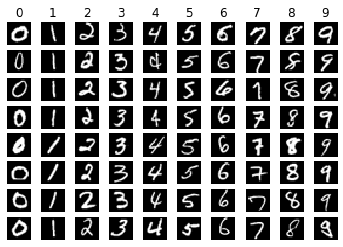

Classification report SKLearn GNB:
              precision    recall  f1-score   support

           0       0.54      0.94      0.69       164
           1       0.71      0.94      0.81       152
           2       0.83      0.50      0.62       155
           3       0.83      0.53      0.65       154
           4       0.75      0.31      0.44       143
           5       0.67      0.16      0.25       141
           6       0.81      0.85      0.83       143
           7       0.83      0.82      0.83       158
           8       0.41      0.64      0.50       132
           9       0.60      0.84      0.70       158

    accuracy                           0.66      1500
   macro avg       0.70      0.65      0.63      1500
weighted avg       0.70      0.66      0.64      1500


Confusion matrix SKLearn GNB:
[[154   0   6   0   1   1   0   0   1   1]
 [  1 143   1   0   0   1   0   1   3   2]
 [ 11   6  77  10   2   1  19   1  27   1]
 [ 32  11   5  82   0   0   2   3  12   7]
 [ 

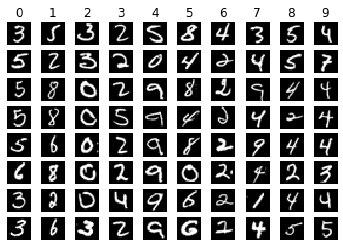

In [18]:
scikit_GaussianNB(data = "mnist")

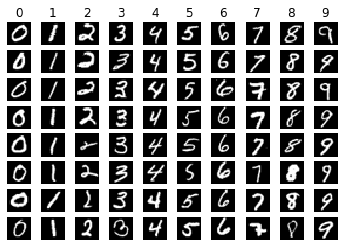

Classification report NearestCentroidClassify:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       164
           1       0.71      0.97      0.82       152
           2       0.84      0.73      0.78       155
           3       0.74      0.76      0.75       154
           4       0.75      0.76      0.75       143
           5       0.72      0.69      0.70       141
           6       0.90      0.86      0.88       143
           7       0.95      0.80      0.87       158
           8       0.79      0.72      0.75       132
           9       0.76      0.80      0.78       158

    accuracy                           0.80      1500
   macro avg       0.81      0.80      0.80      1500
weighted avg       0.81      0.80      0.80      1500


Confusion matrix NearestCentroidClassify:
[[150   0   2   0   0   6   3   1   2   0]
 [  0 148   0   0   0   2   0   0   2   0]
 [  0  15 113   8   2   3   3   1   8   2]
 [  1   5   8 117   1 

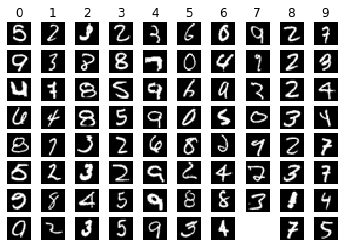

In [19]:
my_NCC(data = "mnist")

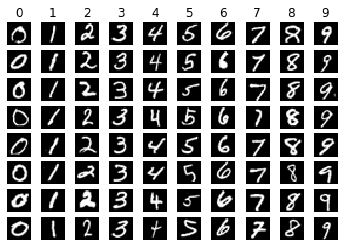

Classification report NaiveBayesianClassifier:
              precision    recall  f1-score   support

           0       0.70      0.18      0.29       164
           1       0.32      0.99      0.48       152
           2       0.75      0.04      0.07       155
           3       0.56      0.25      0.35       154
           4       0.25      0.17      0.21       143
           5       0.24      0.04      0.07       141
           6       0.69      0.50      0.58       143
           7       0.38      0.09      0.14       158
           8       0.15      0.15      0.15       132
           9       0.21      0.66      0.32       158

    accuracy                           0.31      1500
   macro avg       0.42      0.31      0.27      1500
weighted avg       0.43      0.31      0.27      1500


Confusion matrix NaiveBayesianClassifier:
[[ 30  11   1   9  17  11   6   0  41  38]
 [  0 150   0   0   0   0   0   0   1   1]
 [  5  39   6  21  13   7  11   1  31  21]
 [  1  28   1  39   9 

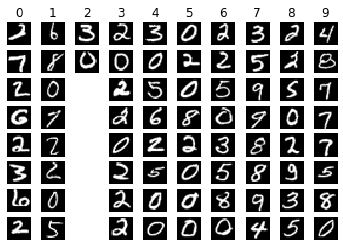

In [20]:
my_NBC(data = "mnist")

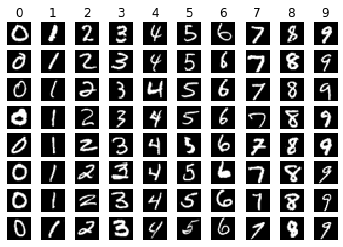

In [ ]:
my_GNBC(data = "mnist")